### Importing scraper and necessary libraries

In [1]:
from scraper import listing_df
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

### Initializing Dataframe 

In [2]:
df = listing_df

### Checking and dropping NaN values if any

In [3]:
print(df.isna().sum())

prop_ID       0
rent_pw       0
suburb        0
avail_date    0
bills_inc     0
prop_pop      0
beds          0
baths         0
dtype: int64


### Exploring dataset

In [4]:
df.describe()

,prop_ID,rent_pw,suburb,avail_date,bills_inc,prop_pop,beds,baths
count,252,252,252,252,252,252,252,252
unique,252,71,142,33,2,8,6,4
top,share-house-sydney-kingswood-2747-P1264952,350,Surry Hills,Available Now,Yes,2,2,2
freq,1,22,6,173,178,63,82,119


### Checking for duplicates

In [5]:
try:
    print(pd.concat(x for _, x in df.groupby("prop_ID") if len(x) > 1))
except ValueError as err:
    print("No duplicates found!")

No duplicates found!


### Removing duplicates if any

In [6]:
df.drop_duplicates(inplace=True)

### Formatting columns to relevant types

In [7]:
 # Removing commas from the rent column
df["rent_pw"] = df["rent_pw"].replace(",","",regex=True)

# Converting beds, baths, rent_pw, prop_pop columns to int
df[["prop_pop","beds","baths","rent_pw"]] = df[["prop_pop","beds","baths","rent_pw"]].apply(pd.to_numeric)

# Removing "Available " from avail_date column
df["avail_date"] = df["avail_date"].replace("Available ","",regex=True)

# Replacing "Now" with today's date
df.loc[(df["avail_date"]=="Now"), "avail_date"] = date.today()

# Converting avail_date column to datetime data type
df["avail_date"] = pd.to_datetime(df["avail_date"]) 

In [8]:
df.head(10)

,prop_ID,rent_pw,suburb,avail_date,bills_inc,prop_pop,beds,baths
0,share-house-sydney-sydney-olympic-park-2127-P1...,550,Sydney Olympic Park,2022-12-21,Yes,3,3,2
1,share-house-sydney-sydney-olympic-park-2127-P1...,450,Sydney Olympic Park,2022-12-21,Yes,3,3,2
2,share-house-sydney-forest-lodge-2037-P1134072,300,Forest Lodge,2022-12-25,Yes,7,6,4
3,share-house-sydney-surry-hills-2010-P525785,300,Surry Hills,2022-12-25,Yes,7,6,4
4,studio-sydney-darlinghurst-2010-P1279699,500,Darlinghurst,2022-12-21,Yes,0,1,1
5,whole-property-sydney-north-ryde-2113-P1092185,400,North Ryde,2022-12-21,Yes,0,3,3
6,share-house-sydney-waterloo-2017-P1272271,450,Waterloo,2022-12-21,Yes,1,2,2
7,share-house-sydney-darlinghurst-2010-P1226177,375,Darlinghurst,2022-12-21,Yes,4,5,2
8,share-house-sydney-kingsford-2032-P1157059,340,Kingsford,2023-01-03,Yes,6,6,3
9,share-house-sydney-petersham-2049-P1231915,475,Petersham,2023-01-08,Yes,6,6,4


### Getting property type from the `prop_ID` column

In [9]:
# Initializing a property type column from the prop_ID column
prop_type = df["prop_ID"].str.split("-sydney", n=1, expand=True)

# Setting prop_type column first array element (first split)
df["prop_type"] = prop_type[0]

# Replacing "-" with spaces to clean up column
df["prop_type"] = df["prop_type"].replace("-"," ",regex=True)

# Capitalizing column values
df["prop_type"] = df["prop_type"].str.capitalize()

In [10]:
df.head(10)

,prop_ID,rent_pw,suburb,avail_date,bills_inc,prop_pop,beds,baths,prop_type
0,share-house-sydney-sydney-olympic-park-2127-P1...,550,Sydney Olympic Park,2022-12-21,Yes,3,3,2,Share house
1,share-house-sydney-sydney-olympic-park-2127-P1...,450,Sydney Olympic Park,2022-12-21,Yes,3,3,2,Share house
2,share-house-sydney-forest-lodge-2037-P1134072,300,Forest Lodge,2022-12-25,Yes,7,6,4,Share house
3,share-house-sydney-surry-hills-2010-P525785,300,Surry Hills,2022-12-25,Yes,7,6,4,Share house
4,studio-sydney-darlinghurst-2010-P1279699,500,Darlinghurst,2022-12-21,Yes,0,1,1,Studio
5,whole-property-sydney-north-ryde-2113-P1092185,400,North Ryde,2022-12-21,Yes,0,3,3,Whole property
6,share-house-sydney-waterloo-2017-P1272271,450,Waterloo,2022-12-21,Yes,1,2,2,Share house
7,share-house-sydney-darlinghurst-2010-P1226177,375,Darlinghurst,2022-12-21,Yes,4,5,2,Share house
8,share-house-sydney-kingsford-2032-P1157059,340,Kingsford,2023-01-03,Yes,6,6,3,Share house
9,share-house-sydney-petersham-2049-P1231915,475,Petersham,2023-01-08,Yes,6,6,4,Share house


### Describing dataset after converting columns to relevant data types

In [11]:
df.describe()

,rent_pw,prop_pop,beds,baths
count,252.000000,252.000000,252.000000,252.000000
mean,354.313492,2.603175,3.186508,1.980159
std,137.717018,1.790098,1.428556,0.848952
min,120.000000,0.000000,1.000000,1.000000
25%,260.000000,1.000000,2.000000,1.000000
50%,345.000000,2.000000,3.000000,2.000000
75%,400.000000,4.000000,4.000000,2.000000
max,1200.000000,7.000000,6.000000,4.000000


## Exploratory Data Analysis

### Checking distribution of rent values

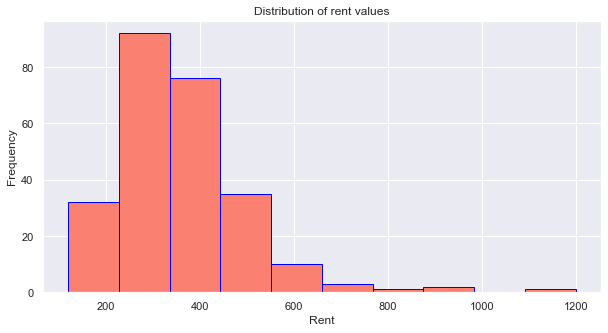

In [13]:
# Plotting frequency histogram to check distribution of rent values
sns.set(rc={"figure.figsize":(10,5)})
plt.hist(df["rent_pw"],color="salmon",edgecolor="blue")

plt.title("Distribution of rent values")
plt.xlabel("Rent")
plt.ylabel("Frequency")
plt.show()

### Heatmap to look for patterns

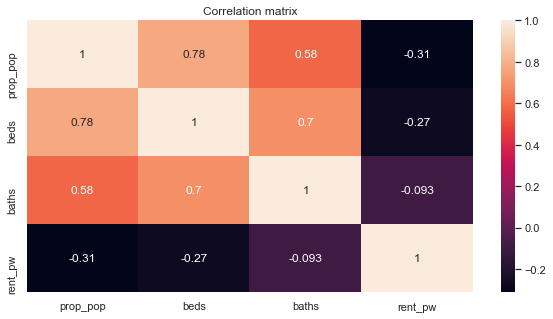

In [14]:
# Creating a view with only numerical values
numerical_data = df[["prop_pop","beds","baths","rent_pw"]]

# creating a heatmap of correlation amongst values
sns.set(rc={"figure.figsize":(10,5)}) 
sns.heatmap(numerical_data.corr(),annot=True)

plt.title("Correlation matrix")
plt.show()

##### Negative correlation amongst rent, beds and bathrooms indicates that rent does not necessarily increase with respect to number of beds and baths.

### Checking rent values

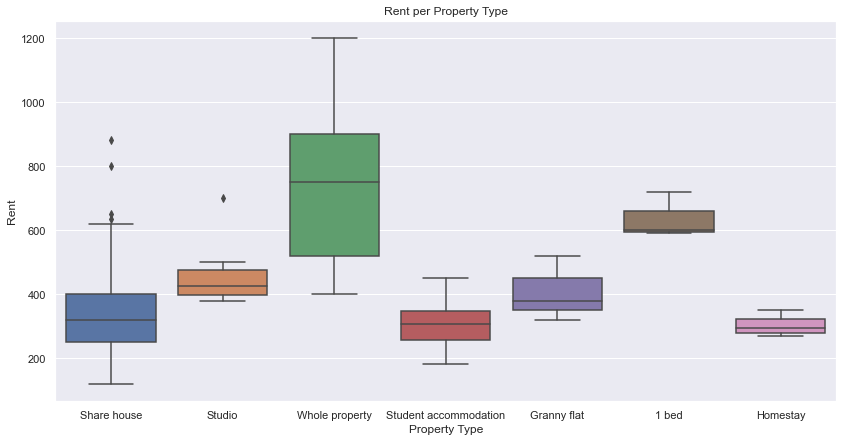

In [26]:
# Checking for more outliers by creating boxplots
sns.set(rc={"figure.figsize":(14,7)})
sns.boxplot(df['prop_type'], df["rent_pw"])
plt.xlabel("Property Type")
plt.ylabel("Rent")
plt.title("Rent per Property Type")
plt.show()

### Finding the minimum rent with bills included

In [16]:
# Creating views where bills are included in rent
view = df.loc[(df["bills_inc"] == "Yes")]

# Getting rows with minimum rent where bills are included
view.loc[(view["rent_pw"] == view["rent_pw"].min())]

,prop_ID,rent_pw,suburb,avail_date,bills_inc,prop_pop,beds,baths,prop_type
67,share-house-sydney-warwick-farm-2170-P879819,120,Warwick Farm,2022-12-21,Yes,1,3,1,Share house


### Finding minimum rent where share houses have 1 bathroom per 2 people

Property population was increased by 1 to simulate the number of bathrooms available per person after one more person moves into the property. 

In [17]:
# Creating bath-to-pop ratio column (rounded to one decimal)
df["bath_to_pop_ratio"] = (df["baths"]/(df["prop_pop"]+1)).round(1)

# Getting share houses where there are atleast 1 bathroom per 2 bedrooms
view = df.loc[(df["bath_to_pop_ratio"] >= 0.5) & (df["prop_type"] == "Share house")]

# getting minimum rent where there are atleast 1 bathroom per 2 bedrooms
view.loc[(view["rent_pw"] == view["rent_pw"].min())]

,prop_ID,rent_pw,suburb,avail_date,bills_inc,prop_pop,beds,baths,prop_type,bath_to_pop_ratio
67,share-house-sydney-warwick-farm-2170-P879819,120,Warwick Farm,2022-12-21,Yes,1,3,1,Share house,0.5


### Share houses with a population between 1 and 3

In [18]:
# Creating views to get share houses with a population in range 1 - 3 (inclusive)
view = df.loc[(df["prop_pop"] >= 1) & (df["prop_pop"] <= 3) & (df["prop_type"] == "Share house")]
view.loc[(view["rent_pw"] == view["rent_pw"].min())]

,prop_ID,rent_pw,suburb,avail_date,bills_inc,prop_pop,beds,baths,prop_type,bath_to_pop_ratio
67,share-house-sydney-warwick-farm-2170-P879819,120,Warwick Farm,2022-12-21,Yes,1,3,1,Share house,0.5


### Average rent by property type

In [19]:
avg_rent_per_prop = df.groupby(["prop_type"], as_index=False).mean()
avg_rent_per_prop = avg_rent_per_prop[["prop_type","rent_pw"]]
avg_rent_per_prop.columns = ["Prop_type","Average Rent"]
avg_rent_per_prop

,Prop_type,Average Rent
0,1 bed,636.666667
1,Granny flat,406.666667
2,Homestay,302.857143
3,Share house,340.414634
4,Student accommodation,304.833333
5,Studio,454.090909
6,Whole property,754.000000


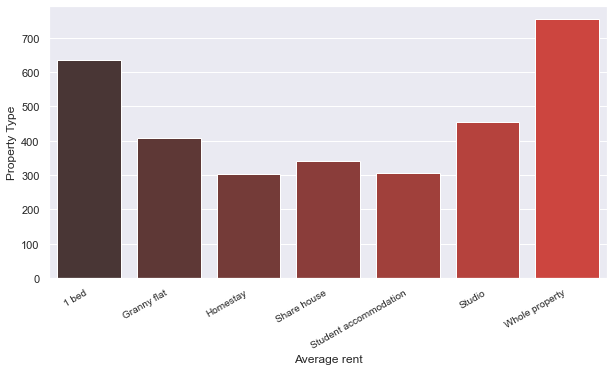

In [28]:
sns.set(rc={"figure.figsize":(10,5)})
palette = sns.color_palette("Reds_d", len(avg_rent_per_prop)+6)
fig = sns.barplot(x=avg_rent_per_prop['Prop_type'],y=avg_rent_per_prop["Average Rent"],palette=palette)
fig.set_xticklabels(fig.get_xticklabels(),fontsize=10, rotation =30, ha="right")
plt.ylabel("Property Type")
plt.xlabel("Average rent")
plt.show() 

### Properties available in the next 10 days

In [ ]:
# Initializing empty column
df["days_to_avail"] = ""

# Converting datetime.date into datetime64 data type
today = pd.to_datetime(date.today())

# Filling column with difference of dates
df["days_to_avail"] = (df["avail_date"] - today)

# Convertin column to string
df["days_to_avail"] = df["days_to_avail"].astype("string")

# Splitting column strings to remove " days"
days = df["days_to_avail"].str.split(" ", n=1,expand=True)

# Replacing column values with numeric part
df["days_to_avail"] = days[0]

# Converting column to numeric
df["days_to_avail"] = pd.to_numeric(df["days_to_avail"])

# Initializing the number of days
days = 10

# Selecting properties that are available in the next 10 days
view = df.loc[(df["days_to_avail"] == days)]

# Printing count of available properties
print(f'{view["prop_ID"].count()} properties available in {days} days')



1 properties available in 10 days
